<a href="https://colab.research.google.com/github/francji1/01RAD/blob/main/python/01RAD_Ex11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


In [ ]:

# Seed for reproducibility
np.random.seed(42)

# Generating simple dataset
n = 50  # Sample size
X1 = np.random.normal(10, 2, n)
X2 = np.random.normal(20, 4, n)
X3 = np.random.normal(0, 0.5, n)  # Noise

# Compute new linear dependent variable for collinearity
X4c = 2 * X1  # New variable - collinearity
X4cn = 2 * X1 + X3  # New variable - collinearity + noise


In [ ]:
# Additional variables for multicollinearity
X5mc = 2 * X1 + X2  # New variable - multicollinearity
X5mcn = 2 * X1 + X2 + X3  # New variable - multicollinearity + noise

# Generating dependent variable
e = np.random.normal(0, 3, n)
Y = 2 * X1 - X2 + e  # without intercept
Y0 = 5 + 2 * X1 - X2 + e  # with intercept

# Forming a DataFrame
mc_data = pd.DataFrame({'Y': Y, 'Y0': Y0, 'X1': X1, 'X2': X2, 'X3': X3, 'X4c': X4c, 'X4cn': X4cn, 'X5mc': X5mc, 'X5mcn': X5mcn})

# Detecting collinearity with correlation matrix
correlation_matrix = mc_data.corr().round(2)

# Displaying correlation matrix
print("Correlation Matrix:\n", correlation_matrix)

# Pair plot for visual inspection of collinearity
sns.pairplot(mc_data)
plt.show()


In [ ]:
# Calculate the correlation matrix
corr = mc_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f")

# Adding title
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()


In [ ]:
# Calculate the correlation matrix
corr = mc_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
import plotly.express as px

# Create an interactive heatmap
fig = px.imshow(corr.round(2), text_auto=True, aspect="auto", color_continuous_scale='RdBu_r')
fig.update_layout(title='Interactive Correlation Heatmap')
fig.show()


In [ ]:
from matplotlib import gridspec

# Define the number of variables
num_vars = len(mc_data.columns)

# Set up the matplotlib figure
plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(num_vars, num_vars)

# Loop through rows and columns to create subplot
for i in range(num_vars):
    for j in range(num_vars):
        ax = plt.subplot(gs[i, j])

        # Upper triangle: scatter plot with regression line
        if i < j:
            sns.regplot(x=mc_data.iloc[:, j], y=mc_data.iloc[:, i], ax=ax)

        # Lower triangle: heatmap
        elif i > j:
            sns.heatmap(mc_data.iloc[:, [i, j]].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=False, ax=ax)

        # Diagonal: histogram
        elif i == j:
            ax.hist(mc_data.iloc[:, i], bins=15)
            ax.set_xlabel(mc_data.columns[i])
            ax.set_ylabel(mc_data.columns[i])

        # Remove axis if not needed
        else:
            ax.axis('off')

        # Adjust layout
        plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
from matplotlib import gridspec

# Define the number of variables
num_vars = len(mc_data.columns)

# Set up the matplotlib figure
plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(num_vars, num_vars)

# Loop through rows and columns to create subplots
for i in range(num_vars):
    for j in range(num_vars):
        ax = plt.subplot(gs[i, j])

        # Upper triangle: scatter plot with regression line
        if i < j:
            sns.regplot(x=mc_data.iloc[:, j], y=mc_data.iloc[:, i], ax=ax)

        # Lower triangle: only off-diagonal correlation value
        elif i > j:
            corr_value = mc_data.iloc[:, [i, j]].corr().iloc[0, 1]
            ax.text(0.5, 0.5, f'{corr_value:.2f}', fontsize=12, ha='center', va='center')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor(sns.color_palette("coolwarm", as_cmap=True)(corr_value / 2 + 0.5))  # Color based on corr_value

        # Diagonal: histogram
        elif i == j:
            ax.hist(mc_data.iloc[:, i], bins=15)
            ax.set_xlabel(mc_data.columns[i])
            ax.set_ylabel(mc_data.columns[i])

        # Remove axis if not needed
        else:
            ax.axis('off')

        # Adjust layout
        plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# OLS fit of 2-variable models
Mc1a = smf.ols('Y ~ X1 + X2', data=mc_data).fit()
Mc1a_no_intercept = smf.ols('Y ~ -1 + X1 + X2', data=mc_data).fit()
Mc1a0 = smf.ols('Y0 ~ X1 + X2', data=mc_data).fit()

# OLS fit of 2-variable model using correlated x4cn or 4c instead of x1
Mc1b = smf.ols('Y ~ X2 + X4c', data=mc_data).fit()
Mc1c = smf.ols('Y ~ X2 + X4cn', data=mc_data).fit()

# OLS fit of 3-variable models
Mc2a = smf.ols('Y ~ X1 + X2 + X4c', data=mc_data).fit()
Mc2a_reordered = smf.ols('Y ~ X2 + X4c + X1', data=mc_data).fit()
Mc2an = smf.ols('Y ~ X1 + X2 + X4cn', data=mc_data).fit()

# OLS fit of 4-variable models
Mc3 = smf.ols('Y ~ X1 + X2 + X5mc', data=mc_data).fit()
Mc3n = smf.ols('Y ~ X1 + X2 + X5mcn', data=mc_data).fit()
Mc4a = smf.ols('Y ~ X1 + X5mcn', data=mc_data).fit()
Mc4b = smf.ols('Y ~ X2 + X5mcn', data=mc_data).fit()

# ANOVA comparisons
anova1 = anova_lm(Mc1b, Mc2an)
anova2 = anova_lm(Mc1c, Mc2an)
anova3 = anova_lm(Mc3, Mc1b)
anova4 = anova_lm(Mc3, Mc4a)
anova5 = anova_lm(Mc3, Mc4b)

# Print summaries of selected models
print("Model Mc1a:\n", Mc1a.summary())
print("\nModel Mc2an:\n", Mc2an.summary())

# Print ANOVA results
print("\nANOVA Mc1b vs Mc2an:\n", anova1)
print("\nANOVA Mc1c vs Mc2an:\n", anova2)
print("\nANOVA Mc3 vs Mc1b:\n", anova3)
print("\nANOVA Mc3 vs Mc4a:\n", anova4)
print("\nANOVA Mc3 vs Mc4b:\n", anova5)


In [ ]:
# Function to calculate VIF
def calculate_vif(df, features):
    X = df[features].copy()  # Create a copy to avoid modifying the original DataFrame
    X['Intercept'] = 1       # Add an intercept for VIF calculation
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data.iloc[:-1]  # Exclude the intercept row from the result

# Compute VIF for the model Y ~ X1 + X2 + X4cn
vif_data1 = calculate_vif(mc_data, ['X1', 'X2', 'X4cn'])
print("VIF for model Y ~ X1 + X2 + X4cn:\n", vif_data1)

# Compute VIF for the model Y ~ X1 + X2
vif_data2 = calculate_vif(mc_data, ['X1', 'X2'])
print("\nVIF for model Y ~ X1 + X2:\n", vif_data2)

# Compute VIF for the model Y ~ X2 + X4cn
vif_data3 = calculate_vif(mc_data, ['X2', 'X4cn'])
print("\nVIF for model Y ~ X2 + X4cn:\n", vif_data3)


In [ ]:
# Manual VIF calculation
def manual_vif(df, feature, other_features):
    model = smf.ols(f'{feature} ~ {" + ".join(other_features)}', data=df).fit()
    rsq = model.rsquared
    return 1 / (1 - rsq)

# Manually compute VIF
vif_X1 = manual_vif(mc_data, 'X1', ['X2', 'X4cn'])
vif_X2 = manual_vif(mc_data, 'X2', ['X1', 'X4cn'])
vif_X4cn = manual_vif(mc_data, 'X4cn', ['X1', 'X2'])

print("\nManual VIF Calculation in model Y ~ X1 + X2 + X4cn")
print("VIF for X1:", vif_X1)
print("VIF for X2:", vif_X2)
print("VIF for X4cn:", vif_X4cn)


In [ ]:
# Compute VIF for the model Y ~ X1 + X2 + X5mcn
vif_data4 = calculate_vif(mc_data, ['X1', 'X2', 'X5mcn'])
print("VIF for model Y ~ X1 + X2 + X5mcn:\n", vif_data4)

# Compute VIF for the model Y ~ X1 + X2
vif_data5 = calculate_vif(mc_data, ['X1', 'X2'])
print("\nVIF for model Y ~ X1 + X2:\n", vif_data5)

# Compute VIF for the model Y ~ X2 + X5mcn
vif_data6 = calculate_vif(mc_data, ['X2', 'X5mcn'])
print("\nVIF for model Y ~ X2 + X5mcn:\n", vif_data6)


In [ ]:
import matplotlib.pyplot as plt

# Assuming vif_data4 is the VIF data for the model Y ~ X1 + X2 + X5mcn
vif_values = vif_data4['VIF']
features = vif_data4['Feature']

plt.figure(figsize=(8, 4))
plt.barh(features, vif_values, color='steelblue')
plt.axvline(x=5, color='red', linestyle='--', linewidth=3)
plt.title("VIF Values")
plt.xlabel("VIF")
plt.ylabel("Features")
plt.show()


In [ ]:
from numpy.linalg import cond
from sklearn.preprocessing import scale
import numpy as np

# Direct computation from the regression matrix
cond_number1 = cond(scale(mc_data[['X1', 'X2', 'X4cn']].values))
cond_number2 = cond(scale(mc_data[['X1', 'X2']].values))

# Computing from the correlation matrix
corr_matrix1 = np.corrcoef(mc_data[['X1', 'X2', 'X4cn']].values, rowvar=False)
cond_number3 = cond(corr_matrix1)

corr_matrix2 = np.corrcoef(mc_data[['X1', 'X2']].values, rowvar=False)
cond_number4 = cond(corr_matrix2)

print("Condition Number (X1, X2, X4cn):", cond_number1)
print("Condition Number (X1, X2):", cond_number2)
print("Condition Number from Correlation Matrix (X1, X2, X4cn):", cond_number3)
print("Condition Number from Correlation Matrix (X1, X2):", cond_number4)


In [ ]:
import numpy as np
from numpy.linalg import cond

# Computing condition number from the correlation matrix
corr_matrix1 = np.corrcoef(mc_data[['X1', 'X2', 'X4cn']].T)
cond_number1 = cond(corr_matrix1)

corr_matrix2 = np.corrcoef(mc_data[['X1', 'X2']].T)
cond_number2 = cond(corr_matrix2)

print("Condition Number from Correlation Matrix (X1, X2, X4cn):", cond_number1)
print("Condition Number from Correlation Matrix (X1, X2):", cond_number2)


In [ ]:
!pip install rpy2
%load_ext rpy2.ipython


In [ ]:
# Pass mc_data to R
%%R -i mc_data

head(mc_data)

# Compute variance inflation factor (Collinearity)
# library(car)
# vif(lm(Y~ X1 + X2 + X4cn))

print(1/(1-(summary(lm(X1   ~ X2 + X4cn,data = mc_data))$r.squared)))
print(1/(1-(summary(lm(X2   ~ X1 + X4cn,data = mc_data))$r.squared)))
print(1/(1-(summary(lm(X4cn ~ X1 + X2,data = mc_data))$r.squared)))


In [ ]:
%%R -i mc_data
#print(mc_data[c("X1","X2","X4cn")])
print(kappa(scale(mc_data[c("X1","X2","X4cn")]),exact=T)^2)
print(kappa(cor(mc_data[c("X1","X2","X4cn")]),exact=T))
print(kappa(cor(mc_data[c("X1","X2")]),exact=T))



In [ ]:
%%R -i mc_data
#print(mc_data[c("X1","X2","X4cn")])
svd_corXcn <- svd(mc_data[c("X1","X2","X4cn")])
print(max(svd_corXcn$d)/min(svd_corXcn$d))
svd_corX <- svd(mc_data[c("X1","X2")])
print(max(svd_corX$d)/min(svd_corX$d))


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

# Example linear models (adjust as per your notebook)
# Model 1: Y ~ X1 + X2 + X3 (without intercept)
model1 = smf.ols('Y ~ X1 + X2 + X3 - 1', data=mc_data).fit()

# Model 2: Y0 ~ X1 + X2 + X3 (with intercept)
model2 = smf.ols('Y0 ~ X1 + X2 + X3', data=mc_data).fit()

# Print model summaries
print(model1.summary())
print(model2.summary())

# ANOVA to compare models
anova_results = anova_lm(model1, model2)
print(anova_results)

# Compute VIF for the models
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(model):
    # Extracting the matrix of explanatory variables from the model
    X = model.model.exog
    vif_data = pd.DataFrame()
    vif_data["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    vif_data["Feature"] = model.model.exog_names
    return vif_data

# Calculating VIF for both models
vif_model1 = calculate_vif(model1)
vif_model2 = calculate_vif(model2)

print("VIF for Model 1:\n", vif_model1)
print("VIF for Model 2:\n", vif_model2)

# Manually computing VIF
# Assuming the same models are used, you'll need to compute the correlation matrix
# and then manually calculate the VIF for each variable.


In [ ]:
# Creating a DataFrame from the generated data
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4c': X4c, 'X4cn': X4cn})

# Basic data exploration (similar to summary() in R)
df_describe = df.describe()

# Check for collinearity (Variance Inflation Factor)
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i)
                       for i in range(len(data.columns))]
    return vif_data

# Calculating VIF for the DataFrame
vif_df = calculate_vif(df)

# Displaying results
print("Data Description:\n", df_describe)
print("\nVariance Inflation Factor:\n", vif_df)


# High Variance vs. High Bias problem

## High Bias
Bias is the algorithm’s tendency to consistently learn the wrong thing by not taking into account all the information in the data (underfitting)

#### Proposals
* Try more complex model.
* Add features (regressors, independent variables)

## High Variance
Variance is the algorithm’s tendency to learn random things irrespective of the real signal by fitting highly flexible models that follow the error/noise in the data too closely (overfitting).

#### Proposals
* Add more training data.
* Try simpler model.
* Remove / reduce some features.
* Add regularization parameters.

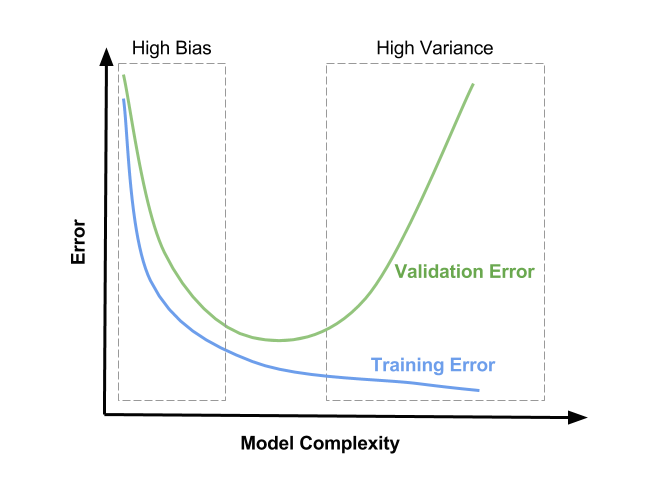


Bias–variance decomposition in linear regression: Use regulariazation techniques such as Lasso, Ridge regression, or Elastic net. Add bias to non-bias OLS estimator to optimize MSE.







### ElasticNet Model a.k.a. From LM to ML

### Motivation
When we have lots of features, we want to be able to penalize their size and number and thus balance the Bias/Variance problem.

Ideally we want to do this by some neat parametrization.




### Regularized loss function !

$L(\hat{y}, y)_{reg} = L(\hat{y}, y) + \lambda * R(\beta)$.

##### The loss function for ElasticNet regression is
$L(\hat{y}, y)_{lasso} = \sum_{p}{(\hat{y}-y)^2} + \lambda * \big[(1-\alpha)/2\sum_{p}{|\beta|} + \alpha \sum_{p}{\beta ^2}\big]$, where $\lambda \in N, \alpha \in [0, 1]$.

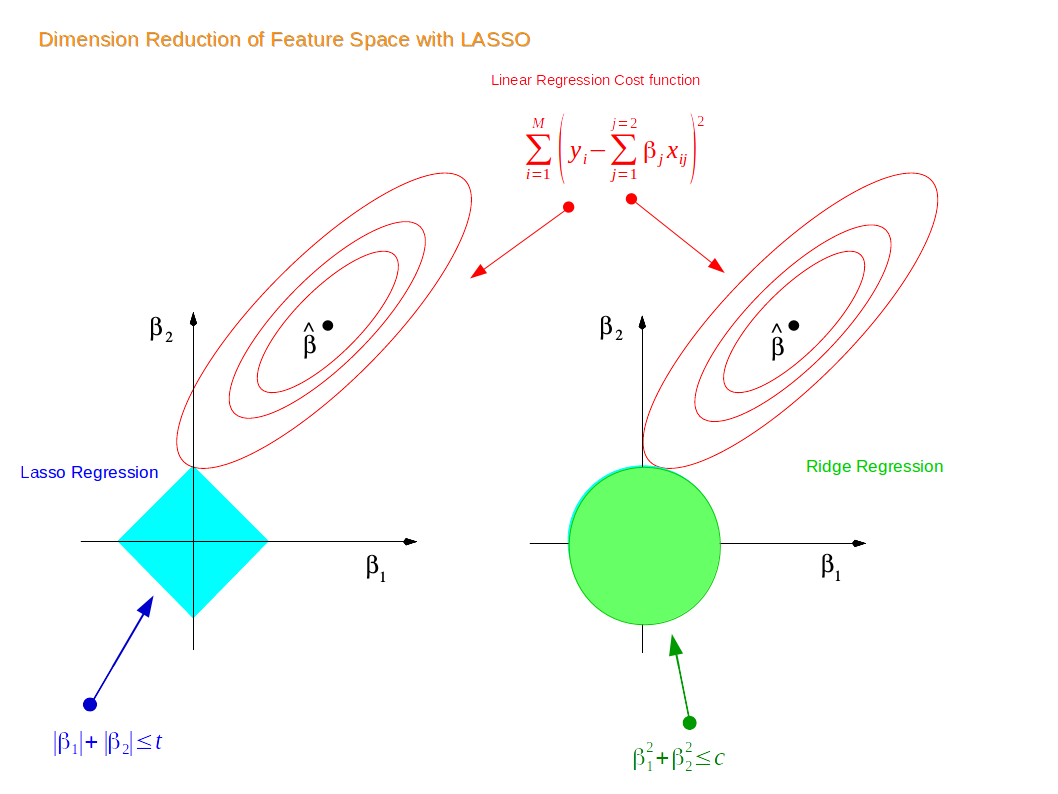



## But how is $\lambda$ set? => CrossValidation!

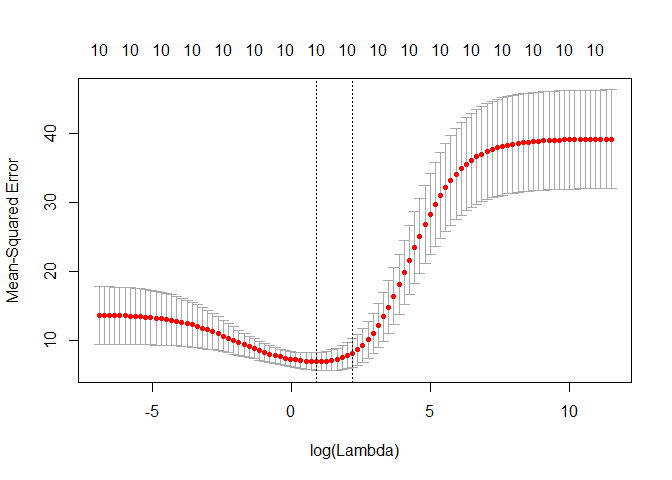




## Overtraining
* It happens if the complexity of the system we have chosen for training is too large for the given dataset.
* The trained system will adapt to the noise instead of to the class differences.
* The solution is either to enlarge the dataset, but, if not possible, to simplify the system.

How to prevent overtrianing? Good Cross validation.



# Cross validation - hyperparameter tunning

Introduction to different cross validation techniques in scikit: https://scikit-learn.org/stable/modules/cross_validation.html

* Train/Validation/Test hold
* K-fold cross-validation, very popular and has become a standard procedure in many papers and works.
* K times K-fold cross-validation, useful for comparing classifiers as the K repeats shrink the standard deviations in the means of the estimated classifier errors.
* K times 2-fold cross-validation helps compute the significance of differences in classification error means.
* Leave-one-out (LOO) cross-validation. In this case the number of folds is equal to the number of objects in the design set.

### K-Fold CV

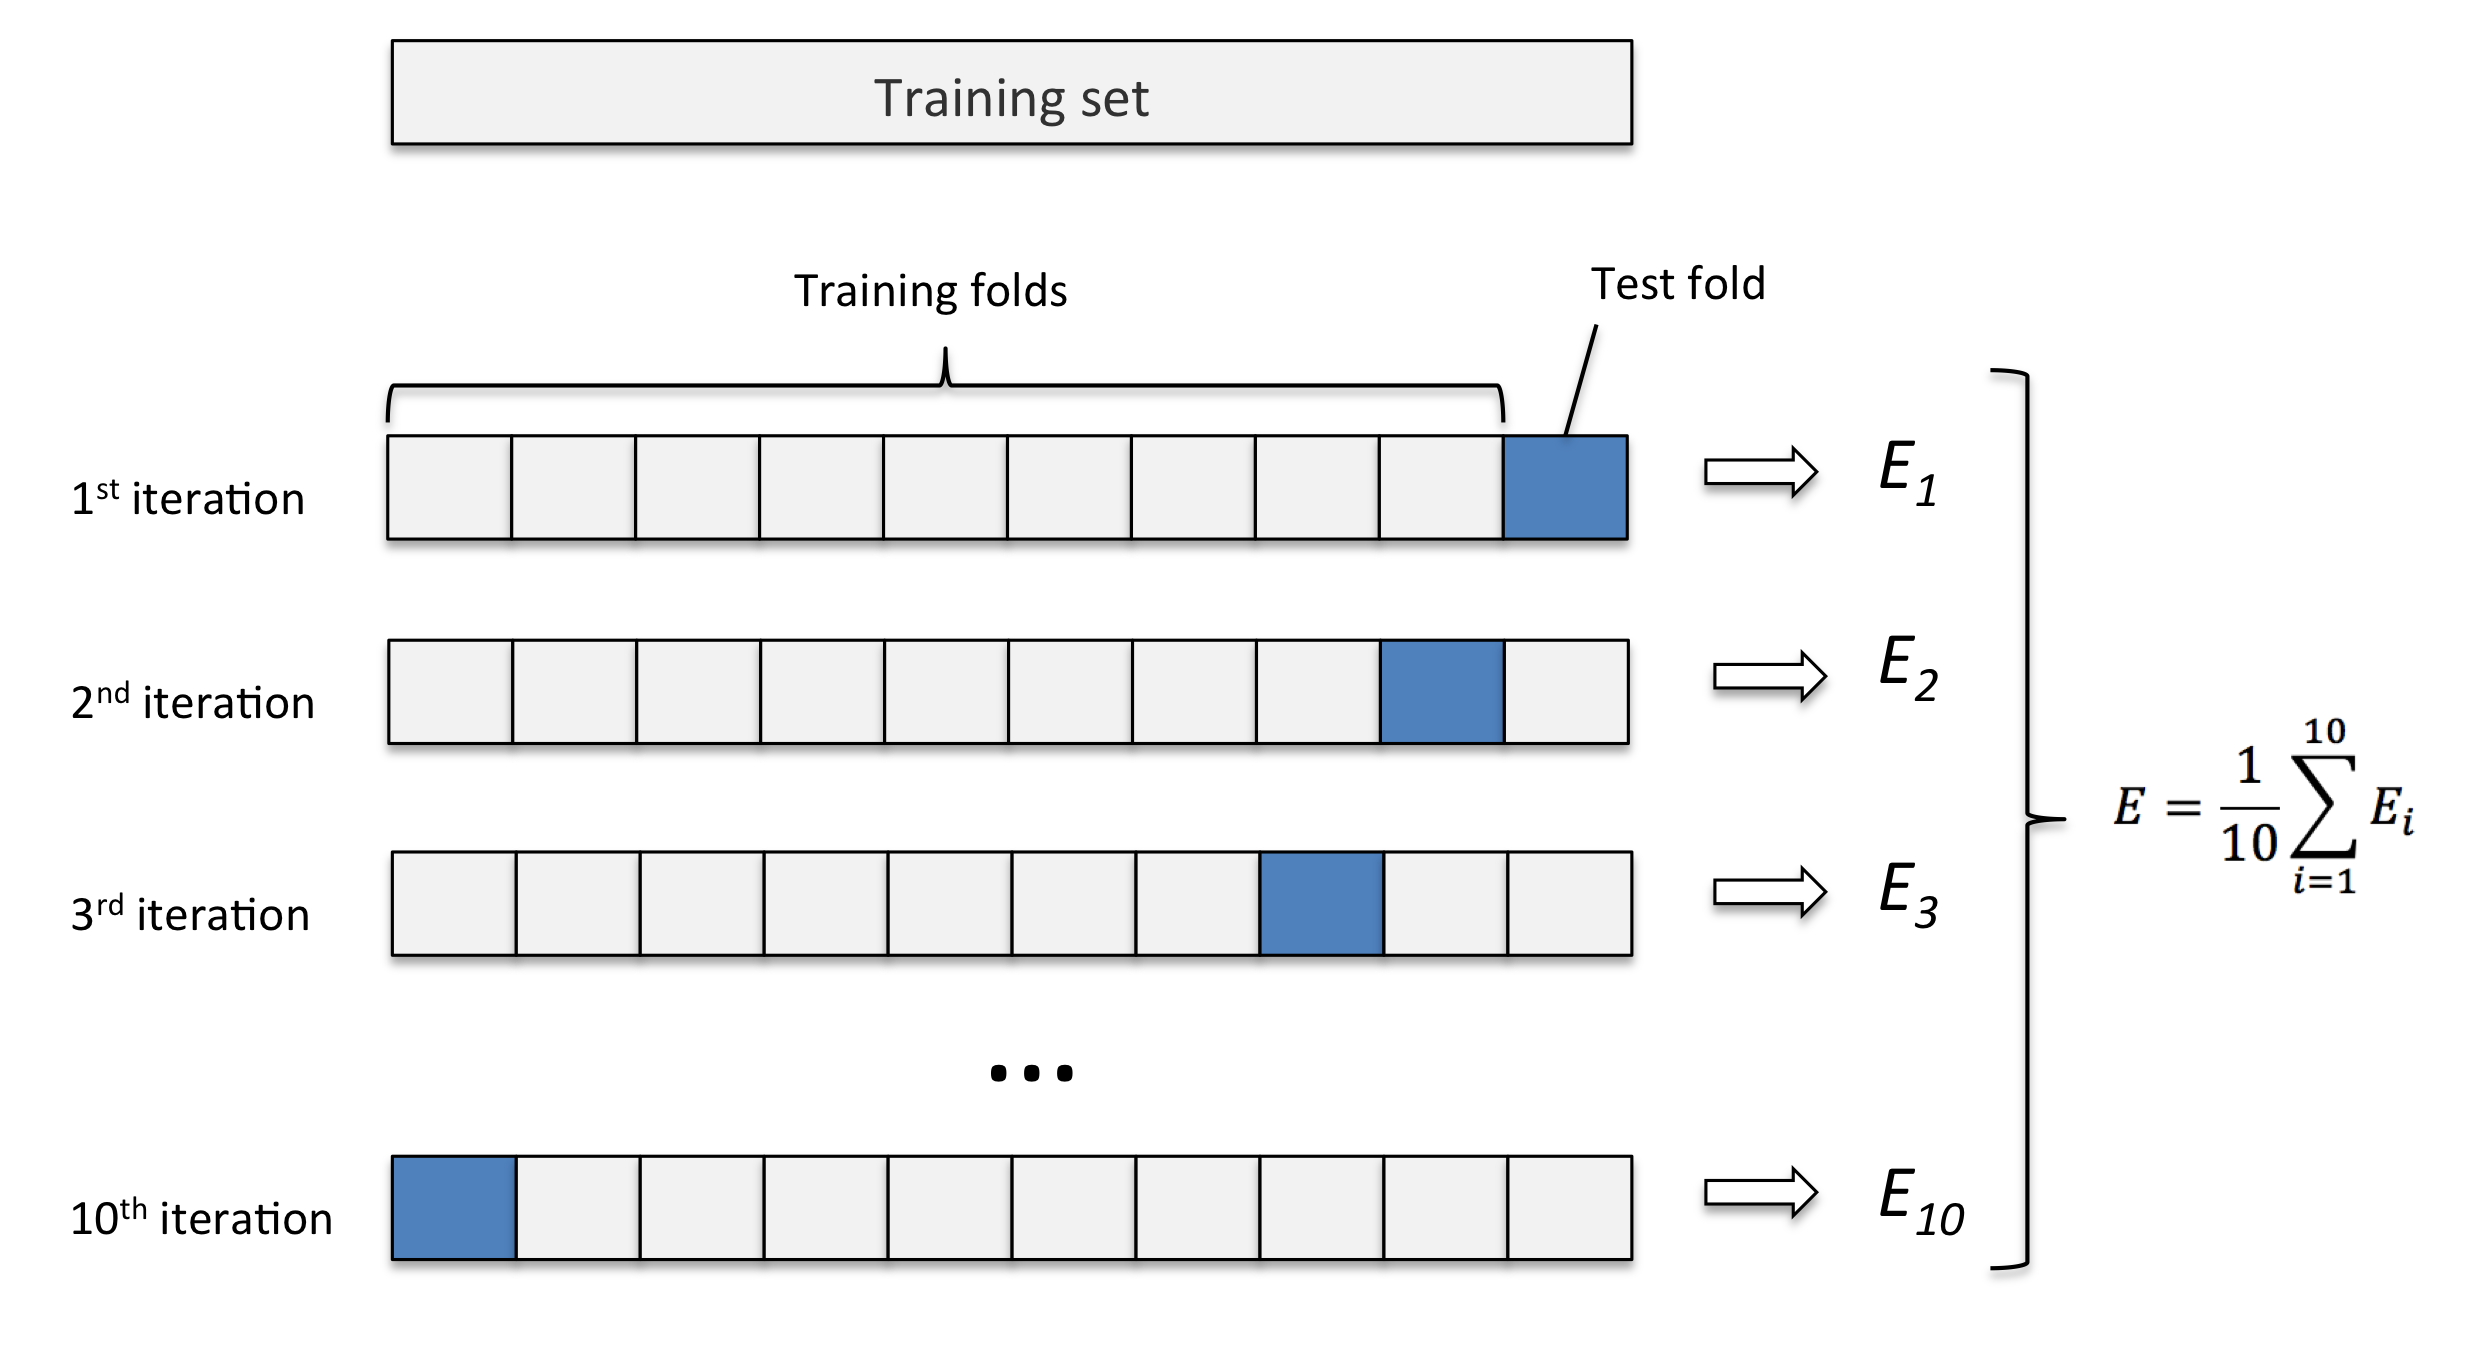



### GridSearch CV Workflow

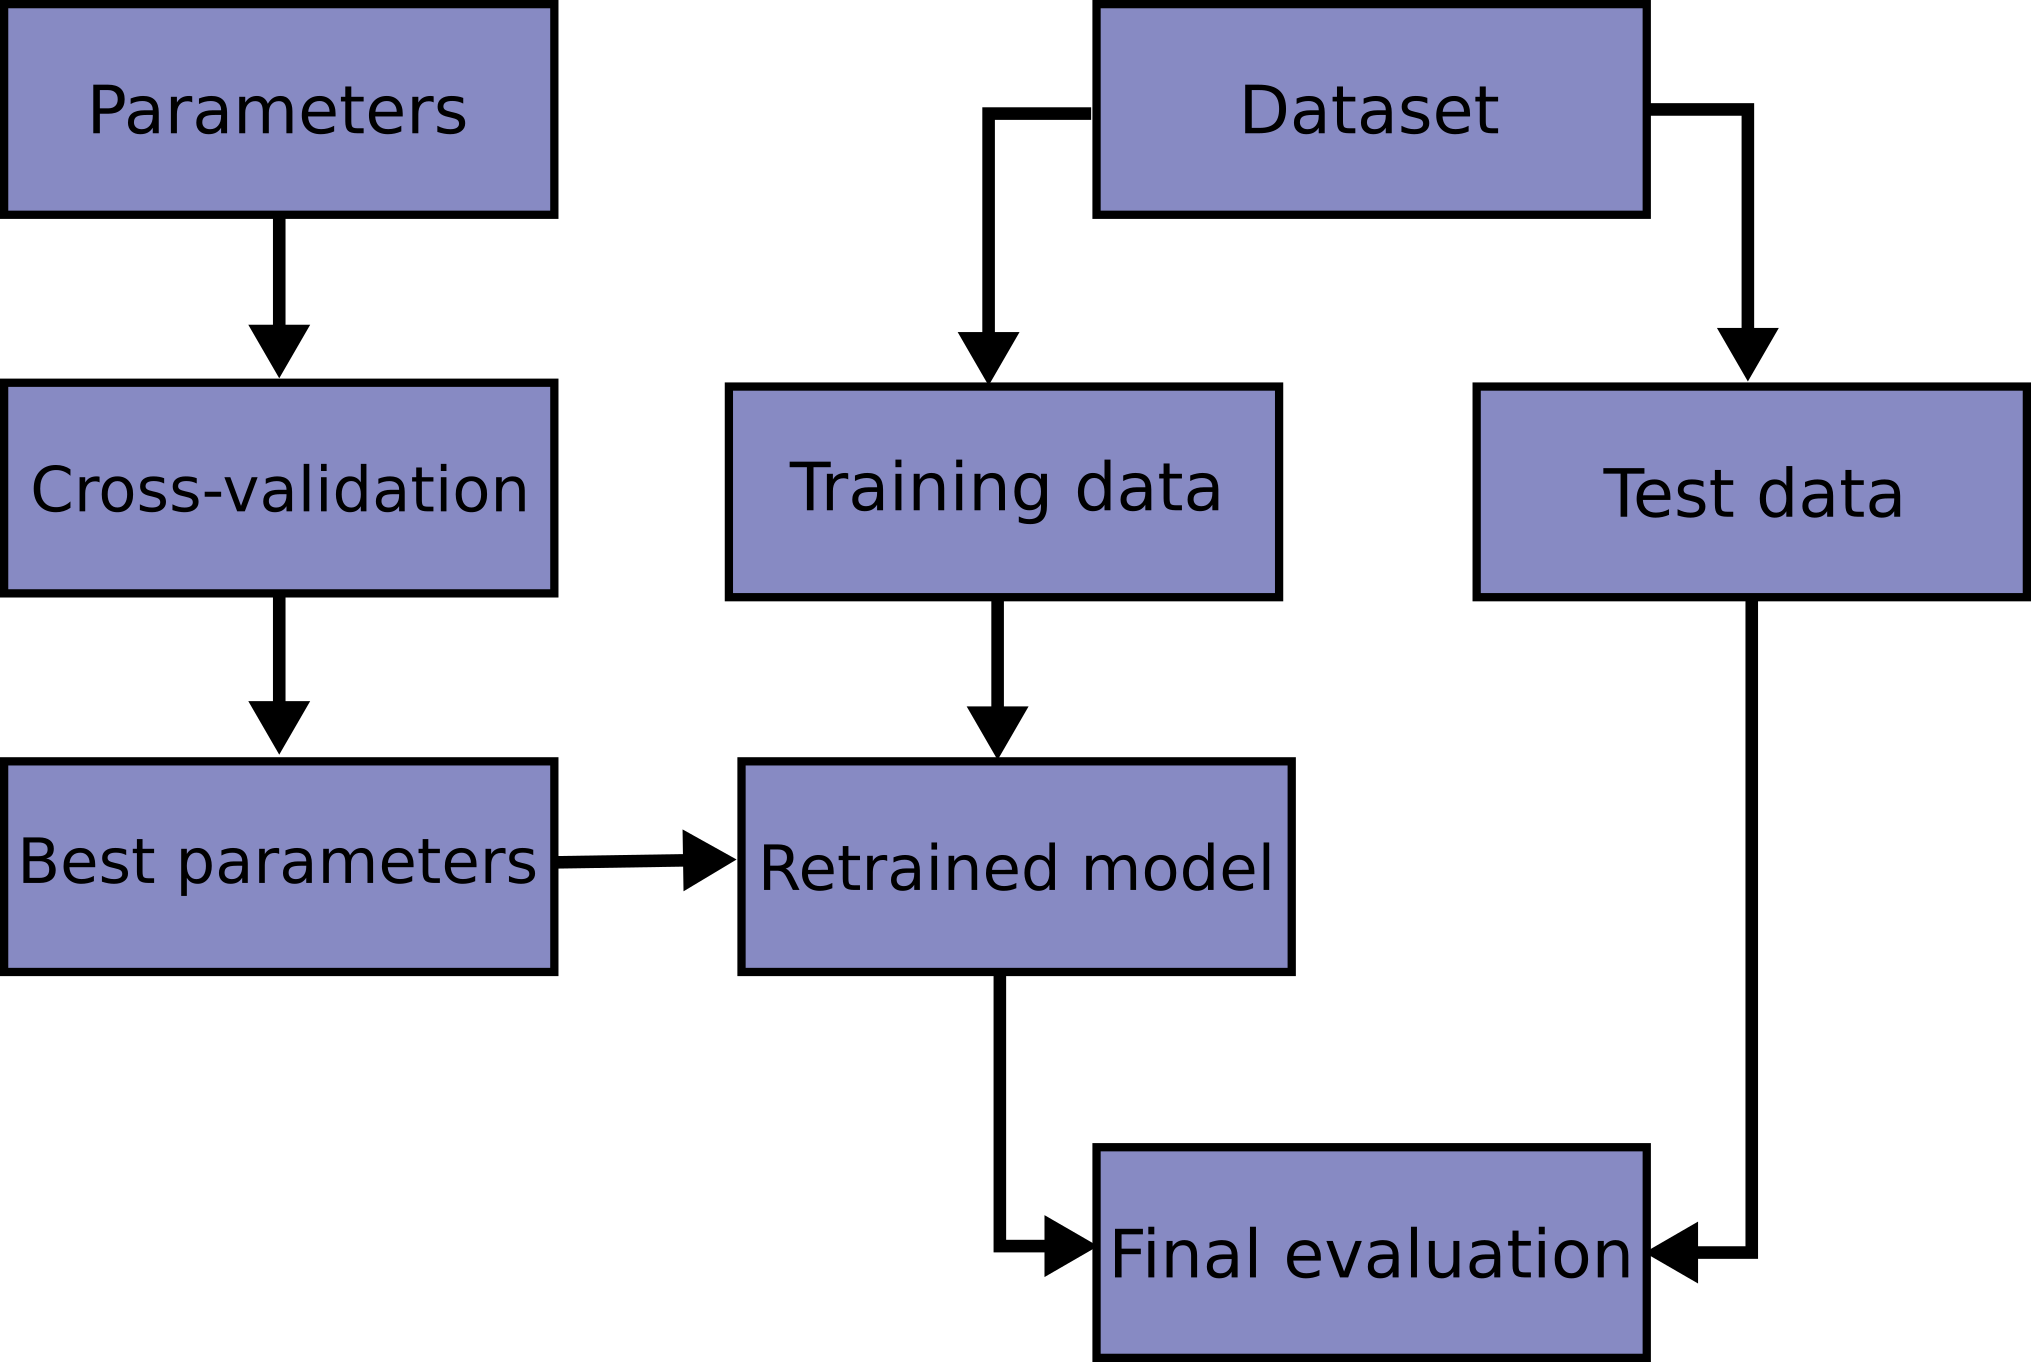

Problems with classic K-fold CV: LEAKING!

With simple K-fold CV we predict on data that we use in training process to adjust our hyperparams!  

Result: The expected error on unseen data is estimated smaller than it should be!!



In [ ]:
mc_data.head()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
import numpy as np

# Assuming 'Y' is the target and the rest are features
X = mc_data.drop(['Y','Y0','X4cn','X5mc','X5mcn'], axis=1)
y = mc_data['Y0']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)


In [ ]:
X.head()

In [ ]:
# Ridge regression with cross-validation
ridge_cv = RidgeCV(alphas=np.logspace(-10, 10, 100), cv=5)
ridge_cv.fit(X_train, y_train)

# Coefficients and best alpha
ridge_intercept = ridge_cv.intercept_
ridge_coefficients = ridge_cv.coef_
best_alpha_ridge = ridge_cv.alpha_
print(ridge_intercept)
ridge_coefficients

In [ ]:
# Lasso regression with cross-validation
lasso_cv = LassoCV(alphas=np.logspace(-10, 10, 100), cv=5)
lasso_cv.fit(X_train, y_train)

# Coefficients and best alpha
lasso_intercept = lasso_cv.intercept_
lasso_coefficients = lasso_cv.coef_
best_alpha_lasso = lasso_cv.alpha_
print(lasso_intercept)
print(lasso_coefficients)

## RIDGE and LASSO REGRESSION in R

In [ ]:


# RIDGE and LASSO REGRESSION in R
# https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net
# https://www.youtube.com/watch?v=ipb2MhSRGdw
# https://rstatisticsblog.com/data-science-in-action/machine-learning/lasso-regression/
# https://rstatisticsblog.com/data-science-in-action/machine-learning/ridge-regression-in-r/
# Tidymodelling with R: https://www.tmwr.org/
# Julia Silge Lasso and Ridge - blog: https://juliasilge.com/blog/lasso-the-office/
# Elastic net tunnig: https://www.kaggle.com/code/issactoast/elastic-net-tunning-with-tidymodels

# For Ridge and Lasso regression we have to scale (standartize) inputs
Xs <- scale(cbind(X1,X2,X5mcn))
Ys <- scale(Y)




In [ ]:

lambdas <- 10^seq(-5, 5, length.out = 100)
# glmnet:  alpha = 0  implements ridge regression
#          alpha = 1  implements LASSO
model_ridge <- glmnet(cbind(X1,X2,X5mcn),Y,  alpha = 0, lambda = lambdas,standardize = T)
#plot(model_ridge, xvar = "lambda", label = TRUE)
#plot(model_ridge, xvar = "norm", label = TRUE)
#plot(model_ridge, xvar = "dev", label = TRUE)


In [ ]:

select(lm.ridge(Y ~ X1 + X2 + X5mcn, lambda =lambdas))

coef(model_ridge) # extract coefficients at a single value of lambda
coef(model_ridge,s=1)


In [ ]:

plot(model_ridge, xvar = "lambda")
legend("bottomright", lwd = 1, col = 1:6, legend = colnames(cbind(X1,X2,X5mcn)), cex = .7)


In [ ]:

model_ridge0 <- glmnet(cbind(X1,X2,X5mcn),Y, alpha = 0 ,standardize = T)


In [ ]:

print(model_ridge0)
coef(model_ridge0,s=0.5) # extract coefficients at a single value of lambda
predict(model_ridge0,newx=cbind(X1 = 1:10,X2 = 2:11, X5mcn = 3:12),s=c(0.01,0.005)) # make predictions



In [ ]:


# k-fold cross-validation
# k = 10
model_ridge_cv <- cv.glmnet(cbind(X1,X2,X5mcn),Y, alpha = 0, lambda = lambdas, standardize = TRUE, nfolds = 10)
plot(model_ridge_cv)



In [ ]:

cv_fit <- cv.glmnet(cbind(X1,X2,X5mcn),Y, alpha = 0.5, nlambda = 1000)
plot(cv_fit)
cv_fit$lambda.min
small_cv_fit <- which(cv_fit$lambda == cv_fit$lambda.min)
betas <- cv_fit$glmnet.fit$beta[, small_cv_fit]
betas
log(cv_fit$lambda.1se)
coef(cv_fit,s = "lambda.min")
coef(cv_fit,s = "lambda.1se")


In [ ]:

#### Lasso by tidymodels
# https://juliasilge.com/blog/lasso-the-office/




In [ ]:
library(MASS)
# Alternative to package glmnet
# We'll use Ridge regression function - ridge.lm() from MASS package
# Ridge regression using independent variables

ridge <- lm.ridge(Y ~ X1+X2+X4cn, lambda = seq(0, 1, .01))
summary(ridge)
select(ridge)
plot(ridge)


In [ ]:

# Ridge regression using correlated variables
ridgec <- lm.ridge(Y ~ X1+X2+X4cn, lambda = seq(0, 5, .02))
plot(ridgec)
select(ridgec)
summary(ridgec)


In [ ]:

# Selection of constant is at endpoint.  Extend endpoint and try again
ridgec <- lm.ridge (Y ~ X1+X2+X4cn, lambda = seq(0, 1, .1))
plot(ridgec)
select(ridgec)
ridgec <- lm.ridge (Y ~ -1 +X1+X2+X4cn, lambda = seq(0, 10, .1))
plot(ridgec)
select(ridgec)



In [ ]:

# Final model uses lambda=1
ridge.final <- lm.ridge (Y ~ -1 + X1+X2+X4cn, lambda = 1)
ridge.final
summary(ridge.final)

#  There's no predict() method for "ridgelm" objects






In [ ]:
library(lars)
data(diabetes)
# Diabetes dataset

data(diabetes)
names(diabetes)
#attach(diabetes)
#detach(diabetes)
Diabetes <- as.data.frame(cbind(diabetes$x,diabetes$y))


In [ ]:

names(Diabetes)[11] <- "y"
summary(Diabetes)
pairs.panels(Diabetes,smooth=F,lm=T,scale=T,pch=20)


In [ ]:

mdia_ols <- lm(y ~ -1+(.),data=Diabetes)
summary(mdia_ols)


In [ ]:

lambdas <- 10^seq(-3, 3)
x = as.matrix(Diabetes[,c(1,2:10)])
y = Diabetes[,11]


In [ ]:

model_ridge <- glmnet(x, y, alpha = 0, lambda = lambdas)
plot(model_ridge, xvar = "lambda", label = TRUE)
cv_fit <- cv.glmnet(x=x, y=y, alpha = 0, nlambda = 1000)
plot(cv_fit)
cv_fit$lambda.min
cv_fit$lambda.1se


In [ ]:


#ridge.dia <- with(Diabetes, lm.ridge (y ~  age+sex+bmi+map+tc+ldl+hdl+tch+ltg+glu, lambda = 10^seq(7, -3)))
ridge.dia <- with(Diabetes, lm.ridge(y ~  age+sex+bmi+map+tc+ldl+hdl+tch+ltg+glu, lambda = seq(0, 10,0.01)))
#ridge.dia <- lm.ridge (y~x, lambda = 10^seq(7, -3))
ridge.dia
plot(ridge.dia)
select(ridge.dia)

fit1 <- glmnet(x=x, y=y, alpha = 0, lambda=cv_fit$lambda.min)
fit2 <- glmnet(x=x, y=y, alpha = 0, lambda=3.2)
with(Diabetes, lm.ridge (y ~  -1+age+sex+bmi+map+tc+ldl+hdl+tch+ltg+glu, lambda = 3.24))
fit1$beta
fit2$beta

mdia_ols$coefficients

train = sample(1:nrow(x), nrow(x)/2)
test = (-train)
ytest = y[test]

mdia_ols_train       <- lm(y~-1+(.), data = Diabetes, subset = train)
mdia_ridge_train     <- glmnet(x[train,], y[train], alpha = 0, lambda = lambdas)
mdia_ridge_cv_fit    <- cv.glmnet(x[train,], y[train], alpha = 0)
lamda_min            <- mdia_ridge_cv_fit$lambda.min

#make predictions
ridge.pred   <- predict(mdia_ridge_train, s = lamda_min, newx = x[test,])
ols.pred     <- predict(mdia_ols_train, newdata = Diabetes[test,])
#check MSE
mean((ols.pred-ytest)^2)
mean((ridge.pred-ytest)^2)





### You task:

In [ ]:
?ISLR::Credit

Credit <- ISLR::Credit
summary(Credit)
dim(Credit)


In [ ]:

#A simulated data set containing information on ten thousand customers. The aim here is to predict
#which customers will default on their credit card debt.

#A data frame with 400 observations on the following.
#ID        Identification
#Income    Income in $10,000’s
#Limit     Credit limit
#Rating    Credit rating
#Cards     Number of credit cards
#Age       Age in years
#Education Number of years of education
#Gender    A factor with levels Male and Female
#Student   A factor with levels No and Yes indicating whether the individual was a student
#Married   A factor with levels No and Yes indicating whether the individual was married
#Ethnicity A factor with levels African American, Asian, and Caucasian
#Balance   Average credit card balance in $


# 1) Zobrazte data a diskutujte mozne vlivne promenne na odezvu "balance"
# 2) Naleznete vhodny model
# 3) Diskutujte vliv promennych Limit a Rating
# 4) Lze Limit nahradit pomoci Rating, nebo mit obe vlivne promenen v model uzaroven?
# 5) Spoctete index podminenosti vysledne regresni matice
#    Spoctete VIF pro dany model obsahujici obe zmine promene, nebo jen jednu znich
# 6) Vyzkousejte hrebenovou regresi a regularizi pomoci Lasso - glmnet
# 7) Overte predpoklady finalniho modelu
# 8) Rozdelte data na dve casti seed(42) a porovnejte MSe u testovaciho samplu pro ols vs ridge reg.


